In [ ]:
!pip install transformers

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=014916bb201f66dc4716879c723033f7da321dc20fe4a9d1c8493972d6b7cb90
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from model import get_model
from dataset import load_data, split_data, get_data_loaders, SpeechDataset, load_data_emodb
from utils import data_distribution
import tensorflow as tf
import numpy as np
import random
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
from google.colab import drive

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import umap.umap_ as umap

disable_eager_execution()
print(tf.executing_eagerly())

random_seed=3
random.seed(random_seed)
np.random.seed(random_seed)

False


In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import librosa
import os
import fnmatch

from google.colab import drive
drive.mount('/content/drive')

def get_files(path, extension):
    files = []
    for root, dirNames, fileNames in os.walk(path):
        for fileName in fnmatch.filter(fileNames, '*' + extension):
            files.append(os.path.join(root, fileName))
    return files

def load_data_emoUERJ(path, extension='.wav'):
    labels_encoded = {'h': 0, 'a': 1, 's': 2, 'n': 3}
    gender_encoded = {'m': 1, 'w': 0}

    if not os.path.isdir(path):
        print('Dataset path does not exist')
        quit()
    else:
        labels = []
        file_paths = []
        gender = []

        # Retrieve all files in chosen path with the specific extension
        audios_path = get_files(path, extension)

        if len(audios_path) == 0:
            print('There is no sample in dataset')
            quit()
        else:
            for file_path in audios_path:
                file_name = os.path.basename(file_path)
                if len(file_name) < 6:
                    print("Invalid file name:", file_path)
                    continue

                gender_key = file_name[0]
                actor_id = file_name[1:3]
                emotion_key = file_name[3]

                if emotion_key not in labels_encoded:
                    print("Invalid emotion in file name:", file_path)
                    continue

                labels.append(labels_encoded[emotion_key])
                gender.append(gender_encoded[gender_key])
                file_paths.append(file_path)

            # Encode labels to digits
            le = preprocessing.LabelEncoder()
            labels = le.fit_transform(labels)
            df = pd.DataFrame({"path": file_paths, "label": labels, "gender": gender})

            return df, le

# Exemplo de uso
data_path = '/content/drive/MyDrive/.../'
df, label_encoder = load_data_emoUERJ(data_path)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                path  label  gender
0  /content/drive/MyDrive/DISSERTAÇÃO/emoUERJ/m04...      0       1
1  /content/drive/MyDrive/DISSERTAÇÃO/emoUERJ/m04...      3       1
2  /content/drive/MyDrive/DISSERTAÇÃO/emoUERJ/m04...      0       1
3  /content/drive/MyDrive/DISSERTAÇÃO/emoUERJ/m04...      0       1
4  /content/drive/MyDrive/DISSERTAÇÃO/emoUERJ/m04...      0       1


In [ ]:
import librosa
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model

#load model
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53")
model = Wav2Vec2Model.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53")

def get_data(dataframe, fe):
  row_count = len(df)
  df_transform = pd.DataFrame(columns=['feature', 'label', 'gender'])

  for index in range(0, row_count):
    array, sr = librosa.load(dataframe["path"][index], sr= 16e3)
    label = int(df['label'][index])
    gender = int(df['gender'][index])

    input = processor(array.squeeze(), sampling_rate=16e3, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**input)
    # extract last hidden state, compute average, convert to numpy
    last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0).numpy()
    extract_features = outputs.extract_features.squeeze().mean(axis=0).numpy()
    df_transform.loc[len(df_transform), ['feature','label','gender']] = extract_features, label, gender

  return df_transform


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-spanish and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df_transform = get_data(df, feature_extractor)

In [ ]:
N = df_transform['feature'].size

float_arr   = np.zeros([N,512])
label = np.zeros(N)
gender = np.zeros(N)

for row in range(N):
    float_arr[row,:] = df_transform['feature'][row]
    label[row] = df_transform['label'][row]
    gender[row] = df_transform['gender'][row]

<ipython-input-62-e59307820292>:9: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'emoUERJ PCA')]

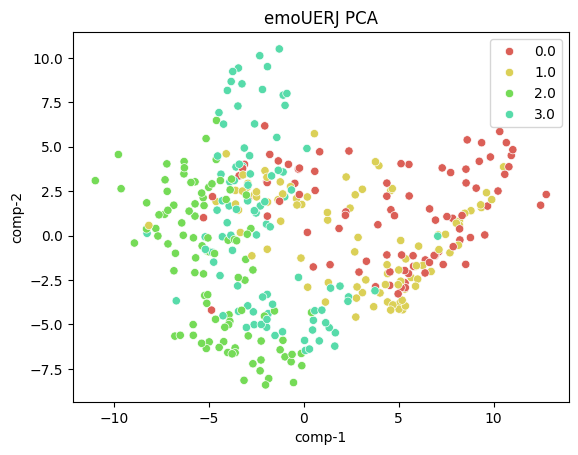

In [ ]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(float_arr)

df = pd.DataFrame()
df["y"] = label
df["comp-1"] = pca_results[:,0]
df["comp-2"] = pca_results[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="emoUERJ PCA")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 377 samples in 0.001s...
[t-SNE] Computed neighbors for 377 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 377 / 377
[t-SNE] Mean sigma: 4.401400
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.385220
[t-SNE] KL divergence after 1000 iterations: 0.453000


<ipython-input-63-6edb43475046>:9: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'emoUERJ')]

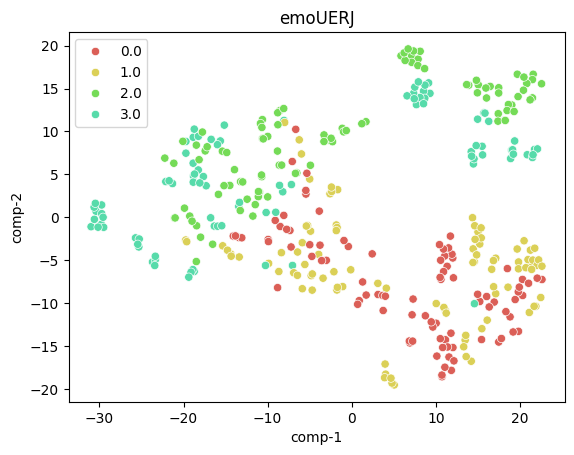

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(float_arr)

df = pd.DataFrame()
df["y"] = label
df["comp-1"] = tsne_results[:,0]
df["comp-2"] = tsne_results [:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="emoUERJ")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[Text(0.5, 1.0, 'emoUERJ')]

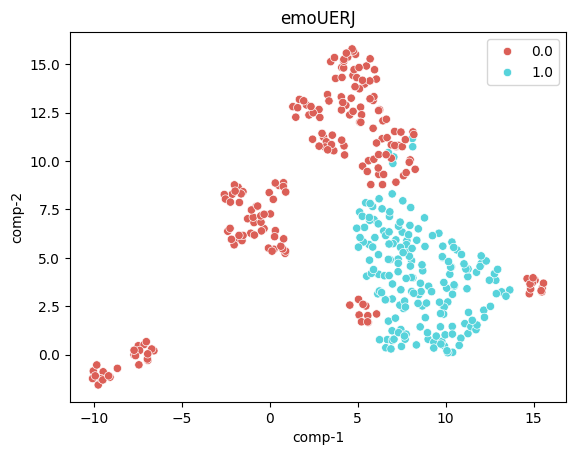

In [ ]:
# UMAP

reducer = umap.UMAP(n_components=2, metric='braycurtis',
                   min_dist=0.8, random_state=42)
umap_results = reducer.fit_transform(float_arr)

df = pd.DataFrame()
df["y"] = gender
df["comp-1"] = umap_results[:,0]
df["comp-2"] = umap_results[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="emoUERJ")